In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure as fig
from pylab import rcParams
import datetime
from datetime import timedelta
import statsmodels.api as sm
rcParams['figure.figsize'] = 20,10
from ResearchClass import PlotEvaluations, EvaluationMetrics, TradesBook, StrategyTemplate
import os

pd.options.mode.chained_assignment = None  # default='warn'

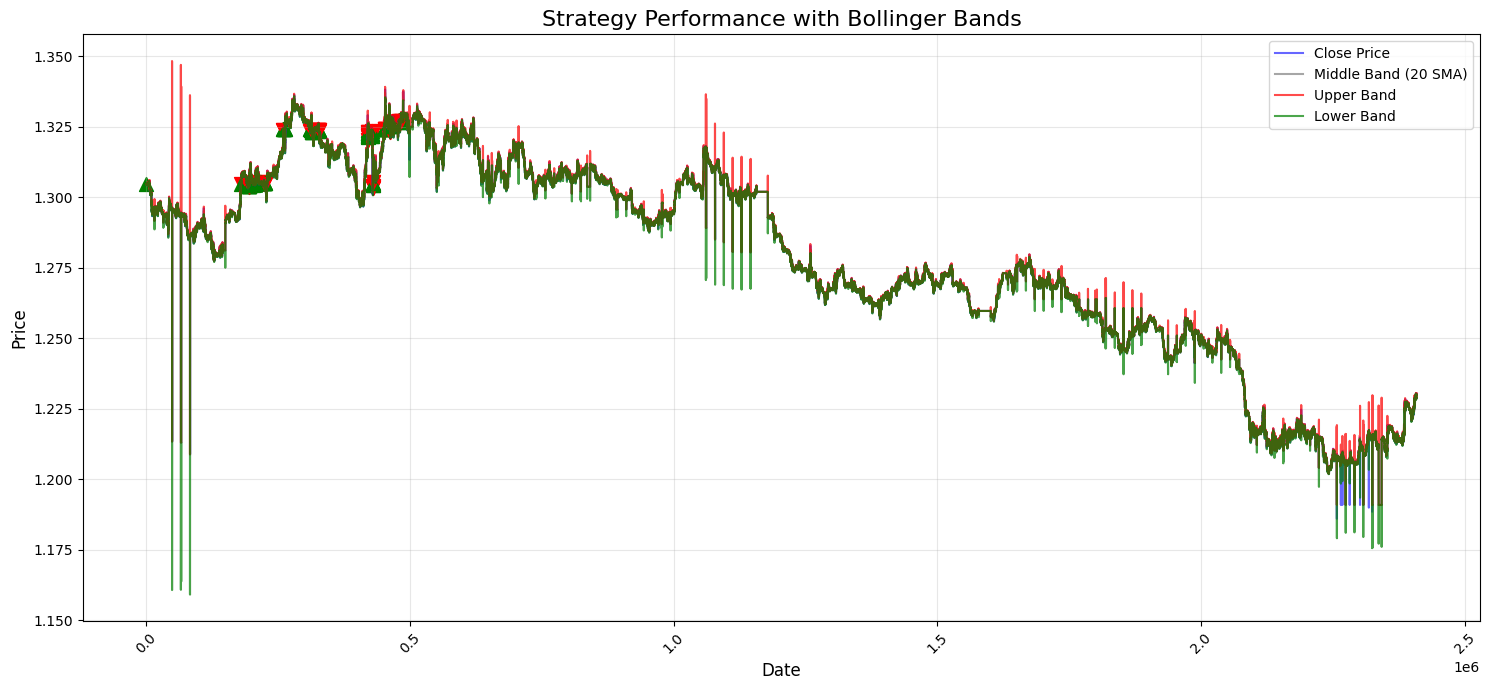

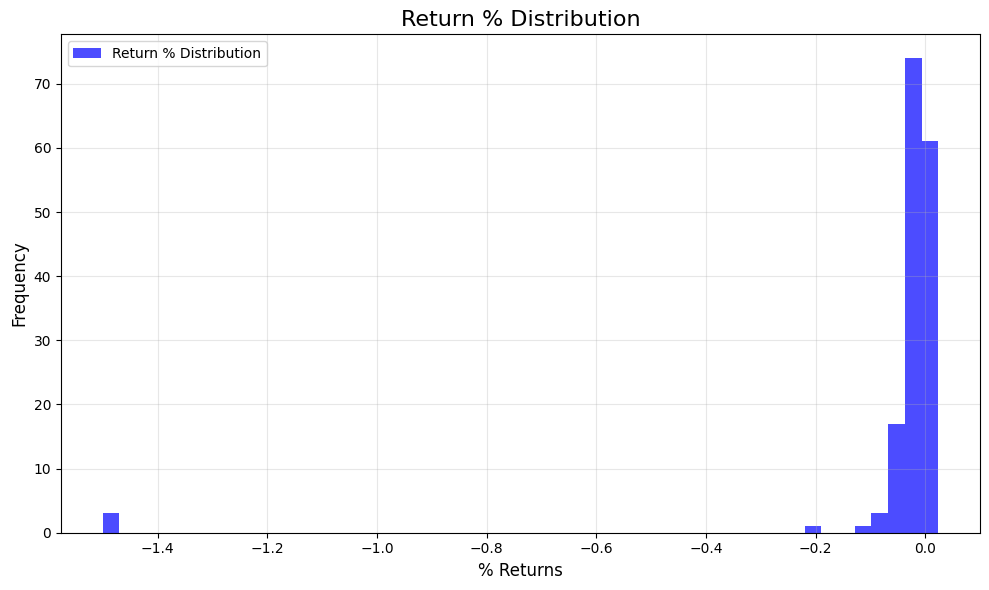

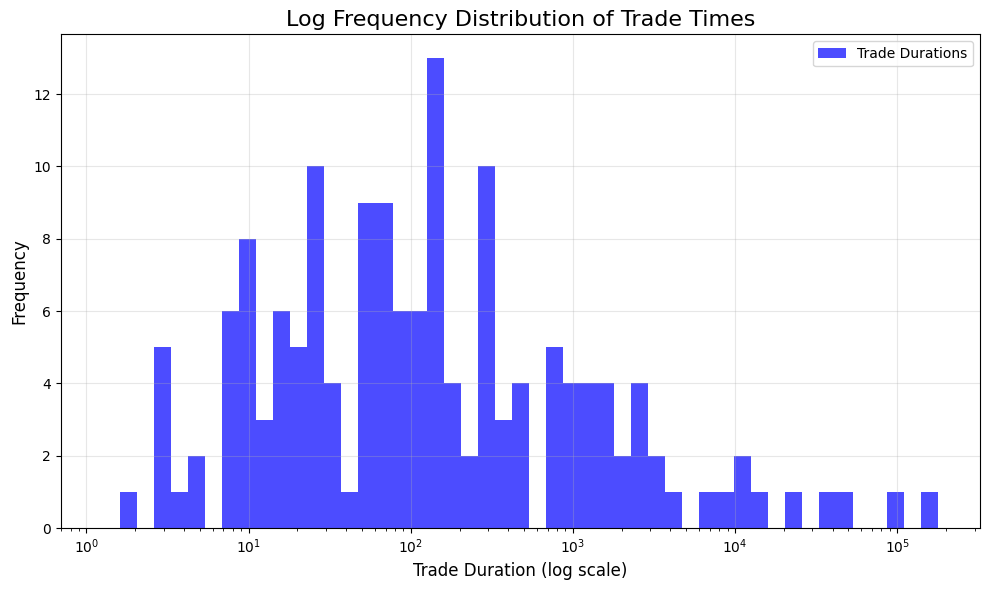

Assets:		 ['Simulated_Ticker']
Start date:	 2024-11-28
End date:	 2025-01-26
Frequency:	 2m
---------------------------
trade_df:	 160
Total return:	 -6.96%
Win rate:	 22.50%
Avg trade:	 -0.043%
Avg win:	 0.006%
Avg loss:	 -0.058%
Avg trade time:	 3017.64
Avg win time:	 245.78
Avg loss time:	 3851.43


In [2]:
class TradesBook:
    def __init__(self, data):
        self.OrderBook = np.zeros(shape=(len(data), 9))
        self.OrderBook[:] = np.nan
        self.trade_count = 0
        self.PositionSize = 0

    def OpenTrade(self, EntryPrice, Sizing, StopLossPrice, EntryIndex, TargetPrice):
        self.OrderBook[self.trade_count, 0] = EntryPrice
        self.OrderBook[self.trade_count, 1] = Sizing
        self.OrderBook[self.trade_count, 2] = StopLossPrice
        self.OrderBook[self.trade_count, 5] = EntryIndex
        self.OrderBook[self.trade_count, 8] = TargetPrice
        self.PositionSize = Sizing

    def CloseTrade(self, ExitPrice, ExitIndex):
        self.OrderBook[self.trade_count, 3] = ExitPrice
        self.OrderBook[self.trade_count, 4] = ExitIndex - self.OrderBook[self.trade_count, 5]
        self.OrderBook[self.trade_count, 6] = ExitIndex
        self.OrderBook[self.trade_count, 7] = self.OrderBook[self.trade_count, 1] * (
            (self.OrderBook[self.trade_count, 3] - self.OrderBook[self.trade_count, 0]) / self.OrderBook[self.trade_count, 0]
        )
        self.trade_count += 1
        self.PositionSize = 0

    def PositionOpen(self):
        if ~np.isnan(self.OrderBook[self.trade_count, 0]) and np.isnan(self.OrderBook[self.trade_count, 3]):
            return True
        else:
            return False

    def CurrentSizing(self):
        if self.PositionOpen():
            return self.OrderBook[self.trade_count, 1]
        else:
            return 0

    def ActiveOrderExecutionPrice(self, row):
        prices = [self.OrderBook[self.trade_count, 2], self.OrderBook[self.trade_count, 8]]
        for price in prices:
            if price < row['High'] and price > row['Low']:
                return price
        else:
            return False

    def ReturnTradeBook(self):
        cols = ['EntryPrice', 'Sizing', 'StopLossPrice', 'ExitPrice', 'TradeDuration', 'EntryIndex', 'ExitIndex', 'Return', 'TargetPrice']
        return pd.DataFrame(self.OrderBook, columns=cols).dropna()

class StrategyTemplate:
    def __init__(self, ticker_list, start_date, end_date, interval, indicator_parameters=[]):
        self.ticker_list = ticker_list
        self.interval = interval
        self.indicator_parameters = indicator_parameters
        self.start_date = start_date
        self.end_date = end_date

    def GetData(self, ticker):
        return pd.read_parquet(f'{ticker}')

    def ApplyStrategyThroughTickers(self):
        TRADE_BOOK = pd.DataFrame()
        for ticker in self.ticker_list:
            self.data = self.GetData(ticker)
            self.AddIndicators()
            ticker_specific_tradebook = self.ApplyStrategyThroughTime(ticker)
            TRADE_BOOK = pd.concat([TRADE_BOOK, ticker_specific_tradebook])
        return TRADE_BOOK

    def ApplyStrategyThroughTime(self, ticker):
        TradeBook = TradesBook(self.data)
        for idx, row in self.data.iterrows():
            if idx == 0:
                continue
            self.strategyLogic(TradeBook, row, idx)
        ticker_specific_tradebook = TradeBook.ReturnTradeBook()
        ticker_specific_tradebook['TICKER'] = ticker
        return ticker_specific_tradebook

    def strategyLogic(self, TradeBook, row, idx):
        pass

    def AddIndicators(self):
        pass

class AMCrossover(StrategyTemplate):
    def AddIndicators(self):
        SHORT_LOOKBACK_PERIOD = self.indicator_parameters[0]
        LONG_LOOKBACK_PERIOD = self.indicator_parameters[1]

        self.data['SMA_SHORT'] = self.data['Close'].rolling(SHORT_LOOKBACK_PERIOD).mean()
        self.data['SMA_LONG'] = self.data['Close'].rolling(LONG_LOOKBACK_PERIOD).mean()

        window = 20
        num_std = 2
        self.data['BB_middle'] = self.data['Close'].rolling(window=window).mean()
        rolling_std = self.data['Close'].rolling(window=window).std()
        self.data['BB_upper'] = self.data['BB_middle'] + (rolling_std * num_std)
        self.data['BB_lower'] = self.data['BB_middle'] - (rolling_std * num_std)

    def strategyLogic(self, TradeBook, row, idx):
        if idx < self.indicator_parameters[1]:
            return

        if TradeBook.CurrentSizing() != 0 and TradeBook.ActiveOrderExecutionPrice(row):
            TradeBook.CloseTrade(TradeBook.ActiveOrderExecutionPrice(row), idx)

        if TradeBook.CurrentSizing() == 0 and self.data['SMA_SHORT'][idx - 1] > self.data['SMA_LONG'][idx - 1]:
            entry = row['Open']
            stop = row['Open'] * (1 - self.indicator_parameters[2])
            target = row['SMA_LONG']
            TradeBook.OpenTrade(entry, 1, stop, idx, target)

        if TradeBook.CurrentSizing() == 0 and self.data['SMA_SHORT'][idx - 1] < self.data['SMA_LONG'][idx - 1]:
            entry = row['Open']
            stop = row['Open'] * (1 + self.indicator_parameters[2])
            target = row['SMA_LONG']
            TradeBook.OpenTrade(entry, -1, stop, idx, target)

def plot_strategy_with_bands(strategy, trade_book):
    plt.figure(figsize=(15, 7))
    plt.plot(strategy.data.index, strategy.data['Close'], label='Close Price', color='blue', alpha=0.6)
    plt.plot(strategy.data.index, strategy.data['BB_middle'], label='Middle Band (20 SMA)', color='gray', alpha=0.7)
    plt.plot(strategy.data.index, strategy.data['BB_upper'], label='Upper Band', color='red', alpha=0.7)
    plt.plot(strategy.data.index, strategy.data['BB_lower'], label='Lower Band', color='green', alpha=0.7)
    plt.fill_between(strategy.data.index, strategy.data['BB_upper'], strategy.data['BB_lower'], alpha=0.1, color='gray')

    for idx, trade in trade_book.iterrows():
        if trade['Sizing'] > 0:
            plt.scatter(strategy.data.index[int(trade['EntryIndex'])], strategy.data['Close'][int(trade['EntryIndex'])], color='green', marker='^', s=100)
            plt.scatter(strategy.data.index[int(trade['ExitIndex'])], strategy.data['Close'][int(trade['ExitIndex'])], color='red', marker='v', s=100)
        else:
            plt.scatter(strategy.data.index[int(trade['EntryIndex'])], strategy.data['Close'][int(trade['EntryIndex'])], color='red', marker='v', s=100)
            plt.scatter(strategy.data.index[int(trade['ExitIndex'])], strategy.data['Close'][int(trade['ExitIndex'])], color='green', marker='^', s=100)

    plt.title('Strategy Performance with Bollinger Bands', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_return_distribution(trade_book):
    """
    Plots the distribution of % returns as a histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(trade_book['Return'] * 100, bins=50, color='blue', alpha=0.7, label='Return % Distribution')
    plt.title('Return % Distribution', fontsize=16)
    plt.xlabel('% Returns', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_log_frequency_distribution(trade_book):
    """
    Plots the log frequency distribution of trade times.
    """
    plt.figure(figsize=(10, 6))

    # Extract trade durations
    trade_durations = trade_book['TradeDuration']

    # Create bins for the histogram
    bins = np.logspace(0.1, np.log10(trade_durations.max() + 1), 50)

    # Plot the histogram
    plt.hist(trade_durations, bins=bins, color='blue', alpha=0.7, label='Trade Durations')

    # Set log scale for x-axis
    plt.xscale('log')

    # Add labels and title
    plt.title('Log Frequency Distribution of Trade Times', fontsize=16)
    plt.xlabel('Trade Duration (log scale)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def print_metrics(trade_book, strategy):
    """
    Prints the metrics for the strategy.
    """
    total_trades = len(trade_book)
    total_return = trade_book['Return'].sum() * 100
    win_rate = len(trade_book[trade_book['Return'] > 0]) / total_trades * 100
    avg_trade = trade_book['Return'].mean() * 100
    avg_win = trade_book[trade_book['Return'] > 0]['Return'].mean() * 100
    avg_loss = trade_book[trade_book['Return'] < 0]['Return'].mean() * 100
    avg_trade_time = trade_book['TradeDuration'].mean()
    avg_win_time = trade_book[trade_book['Return'] > 0]['TradeDuration'].mean()
    avg_loss_time = trade_book[trade_book['Return'] < 0]['TradeDuration'].mean()

    print(f"Assets:\t\t ['Simulated_Ticker']")
    print(f"Start date:\t {strategy.start_date}")
    print(f"End date:\t {strategy.end_date}")
    print(f"Frequency:\t {strategy.interval}")
    print(f"---------------------------")
    print(f"trade_df:\t {total_trades}")
    print(f"Total return:\t {total_return:.2f}%")
    print(f"Win rate:\t {win_rate:.2f}%")
    print(f"Avg trade:\t {avg_trade:.3f}%")
    print(f"Avg win:\t {avg_win:.3f}%")
    print(f"Avg loss:\t {avg_loss:.3f}%")
    print(f"Avg trade time:\t {avg_trade_time:.2f}")
    print(f"Avg win time:\t {avg_win_time:.2f}")
    print(f"Avg loss time:\t {avg_loss_time:.2f}")

# Parameters and setup
parameters = [5, 20, 0.015]
ticker_list = ['./Data/BPc1.parquet']
today = datetime.datetime.now()
start_date = str((today - datetime.timedelta(days=59)).strftime("%Y-%m-%d"))
end_date = str(today.strftime("%Y-%m-%d"))
interval = "2m"

# Apply the strategy
strategy = AMCrossover(ticker_list, start_date, end_date, interval, parameters)
trade_book = strategy.ApplyStrategyThroughTickers()

# Plot strategy with Bollinger Bands
plot_strategy_with_bands(strategy, trade_book)

# Plot Return % Distribution
plot_return_distribution(trade_book)

# Plot Log Frequency Distribution of Trade Times
plot_log_frequency_distribution(trade_book)

# Print metrics
print_metrics(trade_book, strategy)

In [6]:
%pip install fastparquet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
